# Pediatric Bone Age Detection using Hand X-ray
Bone age is an indicator of skeletal maturity. A child’s bone age may or may not exactly match with the child’s age according to his or her birth date. Many factors, such as, nutrition, genetics, hormones, and disease states, influence the development of the skeletal [1]. The bone age study can tell how fast or slowly a child’s skeleton is maturing [2] and it can also provide useful information on many clinical concerns. Clinicians use bone age assessment in order to evaluate the maturity of a child’s skeletal system [3]. Applications that utilize assessment of the skeletal maturity are ever growing. In addition to the medical application, the skeletal maturity assessment can be used in sports selection and forensics to the international immigrant. For example, many children seeking asylum are required to undergo a bone age study so that required resources can be facilitated for them [1].

Data set provided in the [Pediatric Bone Age Challenge(2017)](https://www.rsna.org/en/education/ai-resources-and-training/ai-image-challenge/RSNA-Pediatric-Bone-Age-Challenge-2017) organized by the Radiological Society of North America (RSNA) are used for the child’s bone age prediction. The data set can be downloaded [here](https://stanfordmedicine.app.box.com/s/4r1zwio6z6lrzk7zw3fro7ql5mnoupcv) and includes
* 12,611 hand radiographs for training
* 1,425 hand radiographs for validation
* 200 hand radiographs for testing
* A CSV file with skeletal age estimates and sex of the training and validation images labeled from the accompanying clinical radiology report provided at the time of imaging, and a separate CSV file containing skeletal age estimates and sex of the test images.

#### References
[1] https://pediatrics.aappublications.org/content/140/6/e20171486

[2] https://kidshealth.org/en/parents/xray-bone-age.html

[3] Vladimir Iglovikov, Alexander Rakhlin, Alexandr A. Kalinin, Alexey Shvets “Pediatric Bone Age Assessment Using Deep Convolutional Neural Networks”, bioRxiv 234120


### Problem statement
I am trying to answer the following two quesitons in this work.
* Which model classification or regression neural net provides better age prediction?
* Do two separate models for male and female provide better age prediction comapred to a single model for both?

In order to answer the above questions, the following models will be trained 

* Classification convolution neural net model will be trained on the traning data and skeletel age of the testing data will be predicted.
*Regression convolution neural net model will be trained on the training data and skeletel age of the testing data will be predicted.
*Best of the classification and regression convolution neural net model will be trained on the male training data and skeletel age of the of male testing data will be predicted.
*Best of the classification and regression convolution neural net model will be trained on the female training data and skeletel age of the of female testing data will be predicted.
* Results of all the above models will be analyzed and best model will be determined.

Mount google drive to get access to the data

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [3]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import datetime, os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

## 1. **Data clean up and exploration**<br>
Read training and test CSV files. The train CSV contains three columns (id, boneage, and male) and 12,611 rows. The test CSV file contains two columns(Case ID and Sex) and 200 rows. None of the rows has null value.


In [4]:
# CSV file and iamge directories
# CSV file path + name
csv_train = '/storage/mini_data/mini_train_paperspace.csv'
csv_valid = '/storage/mini_data/mini_valid_paperspace.csv'
csv_test = '/storage/mini_data/Bone-age-ground-truth.csv'
# Image data directories
train_img_dir = '/storage/mini_data/train_mini/'
valid_img_dir = '/storage/mini_data/valid_mini1/'
test_img_dir = '/storage/mini_data/test/'

In [5]:
#loading dataframes
train_df = pd.read_csv(csv_train)
valid_df = pd.read_csv(csv_valid)
test_df = pd.read_csv(csv_test)

In [6]:
# Trian CSV file header
print (train_df.head())

     id  boneage   male
0  1377      180  False
1  1378       12  False
2  1379       94  False
3  1380      120   True
4  1381       82  False


In [7]:
# Validation CSV file header
print (valid_df.head())

   Image ID   male  Bone Age (months)
0      1386  False                 30
1      1392   True                162
2      1397  False                 18
3      1401  False                132
4      1410   True                 57


In [8]:
# Test CSV file header
print (test_df.head())

   Case ID Sex  Ground truth bone age (months)
0     4360   M                          168.93
1     4361   M                          169.65
2     4362   M                           73.26
3     4363   M                          152.86
4     4364   M                          135.46


In [9]:
# train CSV file info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2358 entries, 0 to 2357
Data columns (total 3 columns):
id         2358 non-null int64
boneage    2358 non-null int64
male       2358 non-null bool
dtypes: bool(1), int64(2)
memory usage: 39.3 KB


In [10]:
# Valid CSV file info
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
Image ID             800 non-null int64
male                 800 non-null bool
Bone Age (months)    800 non-null int64
dtypes: bool(1), int64(2)
memory usage: 13.4 KB


In [11]:
# Test CSV file info
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
Case ID                           200 non-null int64
Sex                               200 non-null object
Ground truth bone age (months)    200 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.8+ KB


#### Create image file names by appending '.png' file extension to the id column

In [12]:
train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png')
valid_df['Image ID'] = valid_df['Image ID'].apply(lambda x: str(x)+'.png')
test_df['Case ID'] = test_df['Case ID'].apply(lambda x: str(x)+'.png') 
train_df.head()

id  boneage   male
0  1377.png      180  False
1  1378.png       12  False
2  1379.png       94  False
3  1380.png      120   True
4  1381.png       82  False

### Create male-only and female-only DataFrame

In [13]:
# Dataframe for male only children
train_df_male = train_df[train_df['male']==True]
valid_df_male = valid_df[train_df['male']==True]
train_df_male.head()

id  boneage  male
3  1380.png      120  True
5  1382.png      138  True
6  1383.png      150  True
7  1384.png      156  True
8  1385.png       36  True

In [14]:
# Dataframe for male only children
train_df_female = train_df[train_df['male']==False]
valid_df_female = valid_df[train_df['male']==False]
train_df_female.head()

id  boneage   male
0   1377.png      180  False
1   1378.png       12  False
2   1379.png       94  False
4   1381.png       82  False
10  1388.png      126  False

In [15]:
# Male-only Dataframe info
print (train_df_male.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1316 entries, 3 to 2357
Data columns (total 3 columns):
id         1316 non-null object
boneage    1316 non-null int64
male       1316 non-null bool
dtypes: bool(1), int64(1), object(1)
memory usage: 32.1+ KB
None


In [16]:
# Female-only dataframe info
print (train_df_female.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1042 entries, 0 to 2355
Data columns (total 3 columns):
id         1042 non-null object
boneage    1042 non-null int64
male       1042 non-null bool
dtypes: bool(1), int64(1), object(1)
memory usage: 25.4+ KB
None


**Some EDA- finding out male and female populaiton**

male      1316
female    1042
Name: Sex, dtype: int64


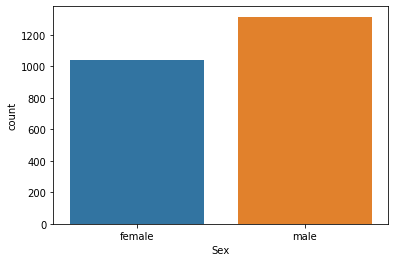

In [17]:
train_df['Sex'] = train_df['male'].apply(lambda x: 'male' if x else 'female')
valid_df['Sex'] = valid_df['male'].apply(lambda x: 'male' if x else 'female')
print(train_df['Sex'].value_counts())
sns.countplot(x = train_df['Sex'])

In [18]:
# Min, Max, and Mean of the childage in training data
train_df.describe()

boneage
count  2358.000000
mean    130.554707
std      46.463449
min       1.000000
25%     106.000000
50%     138.000000
75%     164.000000
max     228.000000

In [19]:
# Feature normalization- total population
mean_age = train_df.boneage.mean()
std_age = train_df.boneage.std()
train_df['scale_bone_age_z'] = (train_df['boneage'] - mean_age)/(std_age)
valid_df['scale_bone_age_z'] = (valid_df['Bone Age (months)'] - mean_age)/(std_age)
train_df.head()

id  boneage   male     Sex  scale_bone_age_z
0  1377.png      180  False  female          1.064176
1  1378.png       12  False  female         -2.551569
2  1379.png       94  False  female         -0.786741
3  1380.png      120   True    male         -0.227162
4  1381.png       82  False  female         -1.045009

In [20]:
# Feature normalization- male population
mean_age_male = train_df_male.boneage.mean()
std_age_male = train_df_male.boneage.std()
train_df_male['scale_bone_age_z'] = (train_df_male['boneage'] - mean_age_male)/(std_age_male)
valid_df_male['scale_bone_age_z'] = (valid_df_male['Bone Age (months)'] - mean_age)/(std_age)
train_df_male.head()

id  boneage  male  scale_bone_age_z
3  1380.png      120  True         -0.337997
5  1382.png      138  True          0.039364
6  1383.png      150  True          0.290939
7  1384.png      156  True          0.416726
8  1385.png       36  True         -2.099019

In [21]:
# Feature normalization- male population
mean_age_female = train_df_female.boneage.mean()
std_age_female = train_df_female.boneage.std()
train_df_female['scale_bone_age_z'] = (train_df_female['boneage'] - mean_age_female)/(std_age_female)
valid_df_female['scale_bone_age_z'] = (valid_df_female['Bone Age (months)'] - mean_age)/(std_age)
train_df_female.head()

id  boneage   male  scale_bone_age_z
0   1377.png      180  False          1.287159
1   1378.png       12  False         -2.541707
2   1379.png       94  False         -0.672856
4   1381.png       82  False         -0.946346
10  1388.png      126  False          0.056452

Text(0.5, 1.0, '# of children vs age')

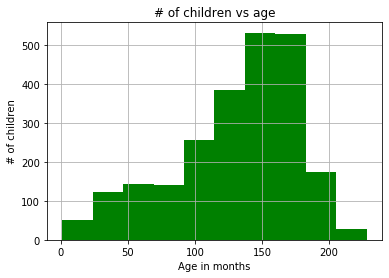

In [22]:
# Plotting a histogram for train bone ages
train_df['boneage'].hist(color = 'green')
plt.xlabel('Age in months')
plt.ylabel('# of children')
plt.title('# of children vs age')

Text(0.5, 1.0, '# of children vs bone age z score')

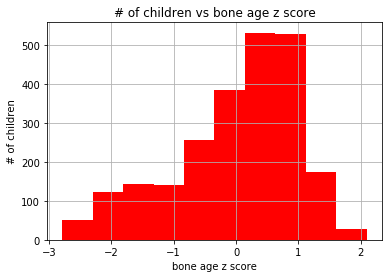

In [23]:
# Plotting a histogram for train bone ages (z-score)
train_df['scale_bone_age_z'].hist(color = 'red')
plt.xlabel('bone age z score')
plt.ylabel('# of children')
plt.title('# of children vs bone age z score')

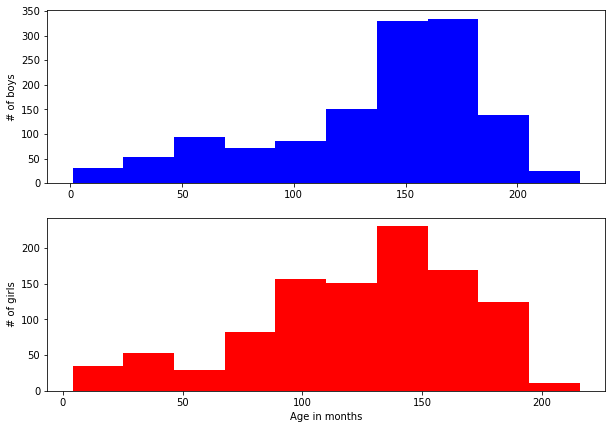

In [24]:
# Distribution of age within each gender 
male = train_df[train_df['Sex'] == 'male']
female = train_df[train_df['Sex'] == 'female']
fig, ax = plt.subplots(2,1)
ax[0].hist(male['boneage'], color = 'blue')
ax[0].set_ylabel('# of boys')
ax[1].hist(female['boneage'], color = 'red')
ax[1].set_xlabel('Age in months')
ax[1].set_ylabel('# of girls')
fig.set_size_inches((10,7))

In [25]:
#Splitting train dataframe into traininng and validation dataframes- female population
# df_train_female, df_valid_female = train_test_split(train_df_female, test_size = 0.2, random_state = 0)
# print (df_train_female.info())
# print (df_valid_female.info())

In [26]:
# # Check if any image file is corrupted or missing
# import matplotlib.image as mpimg
# import os.path
# for filename, boneage, gender in train_df[['id','boneage','Sex']].values:
#     if not os.path.isfile(train_img_dir + filename): 
#         print ('This file does not exist-' + filename)
#     else:
#         try: img = mpimg.imread(train_img_dir + filename)
#         except OSError: print (filename)

In [27]:
# # Check if any image file is corrupted or missing

# for filename, boneage, gender in valid_df[['Image ID','Bone Age (months)','Sex']].values:
#     if not os.path.isfile('/storage/mini_data/valid_mini1/' + filename): 
#         print ('This file does not exist-' + filename)
#     else:
#         try: img = mpimg.imread('/storage/mini_data/valid_mini1/' + filename)
#         except OSError: print (filename)

## Visual inspection of some sample images


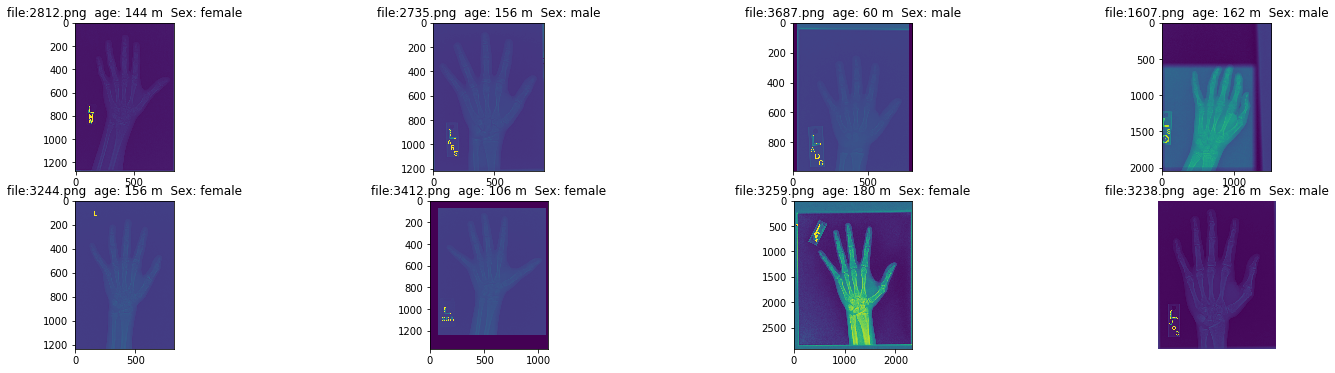

In [28]:
import matplotlib.image as mpimg
fig, axs = plt.subplots(2,4, figsize=(25, 6), facecolor='w', edgecolor='k')
plt_num =0
axs = axs.ravel()

for filename, boneage, Sex in train_df[['id','boneage','Sex']].sample(8).values:
    img = mpimg.imread(train_img_dir + filename)
    
    axs[plt_num].imshow(img)
    axs[plt_num].set_title('file:{}  age: {} m  Sex: {}'.format(filename, boneage, Sex))
    plt_num += 1
plt.axis('off')
plt.show()

In [29]:
import keras
keras.__version__


Using TensorFlow backend.


'2.2.4'

In [30]:
import tensorflow
tensorflow.__version__

'2.3.1'

**Setting up Image Data Generators!**<br>
We use image data generators for both training, testing and preprocessing of images. Validation set is already broken off from training set. 

In [31]:
#library required for image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from  keras.applications.xception import preprocess_input 

#reducing down the size of the image 
img_size = 256

train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
valid_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

#train data generator
train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = train_img_dir,
    x_col= 'id',
    y_col= 'scale_bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode= 'raw',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

#validation data generator
valid_generator = valid_data_generator.flow_from_dataframe(
    dataframe = valid_df,
    directory = valid_img_dir,
    x_col = 'Image ID',
    y_col = 'scale_bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'raw',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

#test data generator
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_data_generator.flow_from_directory(
    directory = test_img_dir,
    shuffle = False,
    class_mode = None,
    color_mode = 'rgb',
    target_size = (img_size,img_size))

# test_generator = test_data_generator.flow_from_dataframe(
#     dataframe = test_df,
#     directory = test_img_dir,
#     x_col = 'Case ID',
#     y_col = 'Ground truth bone age (months)',
#     batch_size = 200,
#     seed = 42,
#     shuffle = False,
#     class_mode = 'raw',
#     flip_vertical = True,
#     color_mode = 'rgb',
#     target_size = (img_size, img_size))

Found 2358 validated image filenames.
Found 800 validated image filenames.
Found 200 images belonging to 1 classes.


In [32]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [33]:
test_X, test_Y = next(valid_data_generator.flow_from_dataframe( 
                            valid_df, 
                            directory = valid_img_dir,
                            x_col = 'Image ID',
                            y_col = 'scale_bone_age_z', 
                            target_size = (img_size, img_size),
                            batch_size = 256,
                            class_mode = 'raw'
                            )) 

Found 800 validated image filenames.


In [34]:
# test_X, test_Y = next(val_datagen.flow_from_dataframe( 
#                             df_valid, 
#                             directory = '/storage/mini_data/minidata/',
#                             x_col = 'id',
#                             y_col = 'scale_bone_age_z', 
#                             target_size = (img_size, img_size),
#                             batch_size = 32,
#                             class_mode = 'raw'
#                             )) 

 The function to plot training and validation error as a function of epochs

In [35]:
def plot_it(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()

In [36]:
from keras.metrics import mean_absolute_error
def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((std_age*x_p + mean_age), (std_age*y_p + mean_age)) 

### Pre-trained Model VGG16

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
model=Sequential()
model.add(VGG16(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))
model.layers[0].trainable=False
model.compile(loss='mse', optimizer='adam', metrics = [mae_in_months])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               16777728  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0

Epoch 1/20
73/73 [==============================] - 353s 5s/step - loss: 6.7072 - mae_in_months: 75.0326 - val_loss: 1.1713 - val_mae_in_months: 39.6939
Epoch 2/20
73/73 [==============================] - 398s 5s/step - loss: 0.8395 - mae_in_months: 33.8340 - val_loss: 0.9285 - val_mae_in_months: 34.8791
Epoch 3/20
73/73 [==============================] - 381s 5s/step - loss: 0.6108 - mae_in_months: 28.8015 - val_loss: 0.7941 - val_mae_in_months: 32.4211
Epoch 4/20
73/73 [==============================] - 380s 5s/step - loss: 0.5183 - mae_in_months: 26.3684 - val_loss: 0.7531 - val_mae_in_months: 31.2793
Epoch 5/20
73/73 [==============================] - 384s 5s/step - loss: 0.4455 - mae_in_months: 24.7404 - val_loss: 0.6472 - val_mae_in_months: 28.8806
Epoch 6/20
73/73 [==============================] - 379s 5s/step - loss: 0.4070 - mae_in_months: 23.1077 - val_loss: 0.7117 - val_mae_in_months: 30.3608
Epoch 7/20
73/73 [==============================] - 382s 5s/step - loss: 0.3961 - 

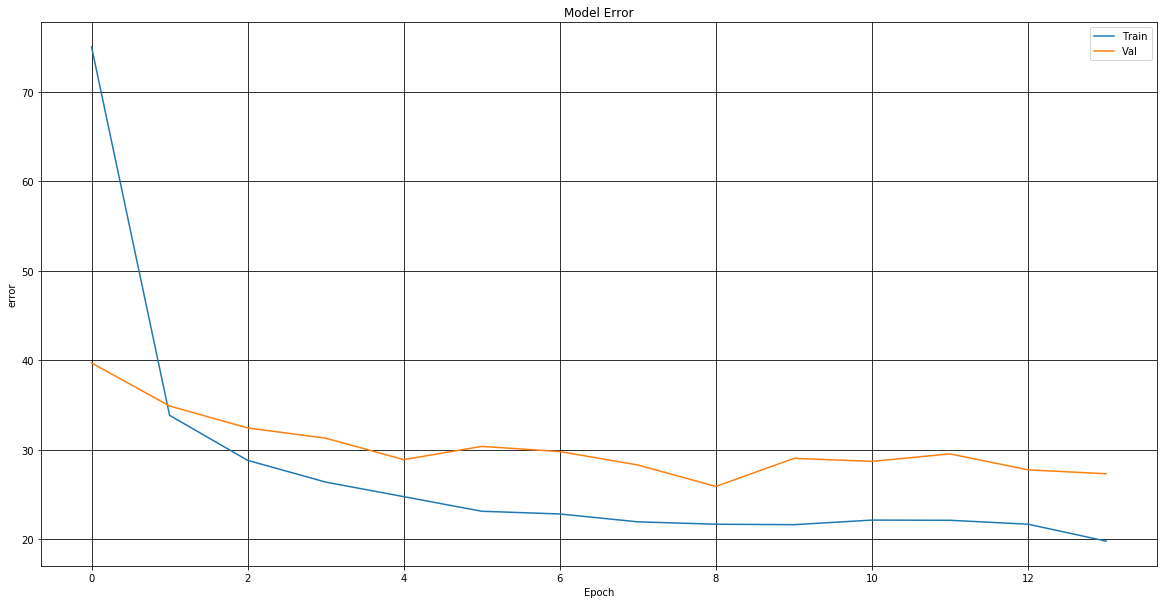

In [40]:
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 5,
                              verbose=0, mode='auto')
#model checkpoint
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

#reduce lr on plateau
red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# callbacks = [tensorboard_callback,early_stopping,mc, red_lr_plat]
callbacks = [early_stopping,mc, red_lr_plat]

#fit model
history = model.fit(train_generator,
                            steps_per_epoch = STEP_SIZE_TRAIN,
                            validation_data = valid_generator,
                            validation_steps = STEP_SIZE_VALID,
                            epochs = 20,
                            callbacks= callbacks)
history
plot_it(history)

Evaluating the best saved model on the validation data and visualising results!!

8/8 [==============================] - 23s 3s/step


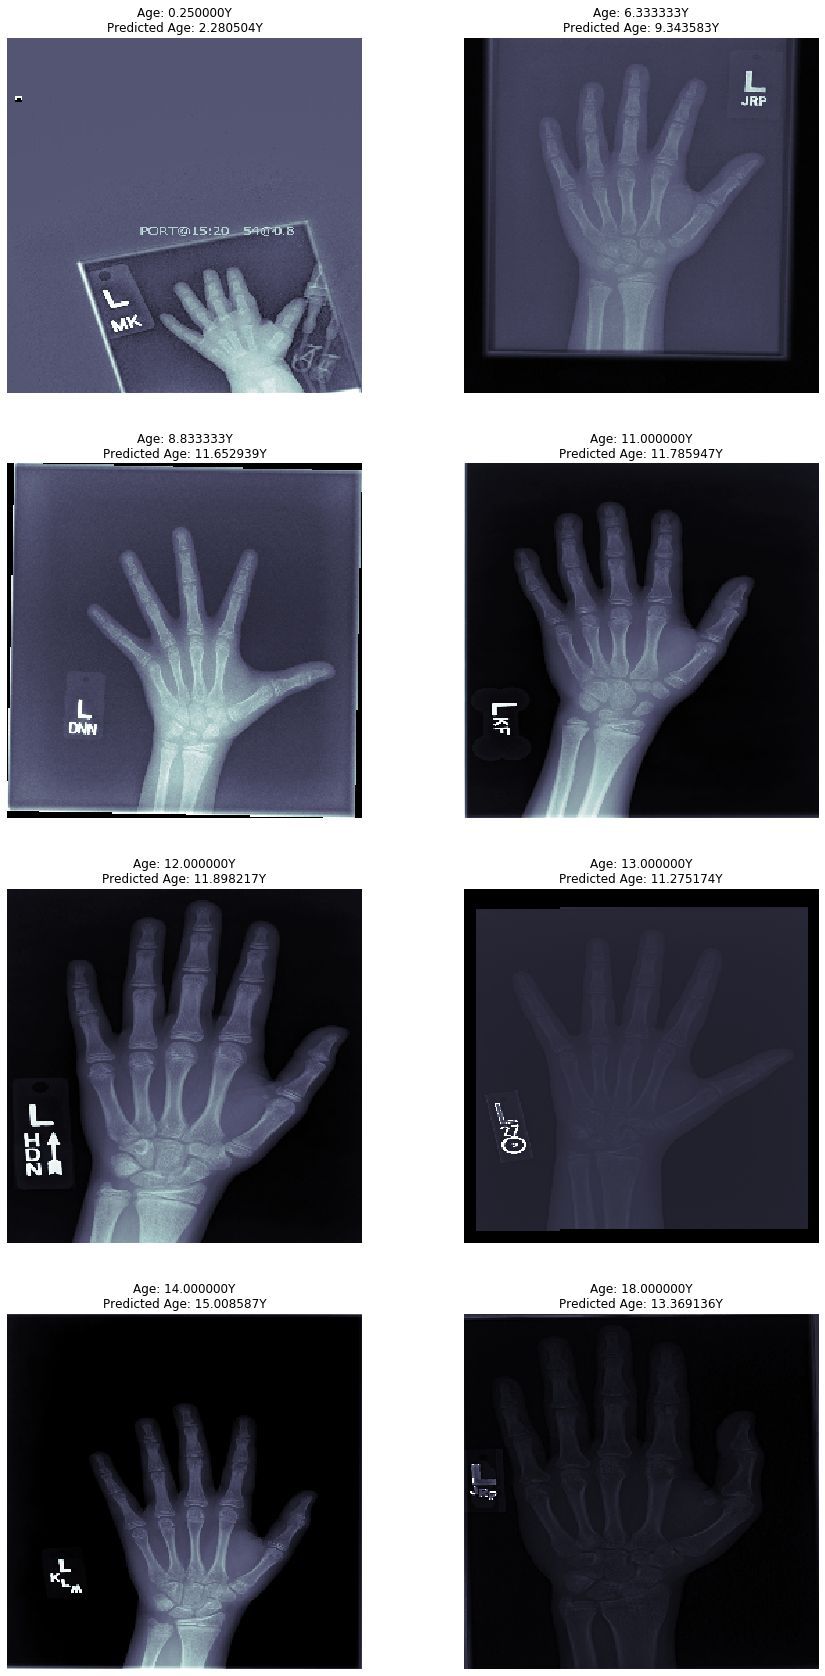

In [40]:
model.load_weights('best_model.h5')
pred = mean_age + std_age*(model.predict(test_X, batch_size = 32, verbose = True))
test_months = mean_age + std_age*(test_Y)

ord_ind = np.argsort(test_Y)
ord_ind = ord_ind[np.linspace(0, len(ord_ind)-1, 8).astype(int)] # take 8 evenly spaced ones
fig, axs = plt.subplots(4, 2, figsize = (15, 30))
for (ind, ax) in zip(ord_ind, axs.flatten()):
    ax.imshow(test_X[ind, :,:,0], cmap = 'bone')
    ax.set_title('Age: %fY\nPredicted Age: %fY' % (test_months[ind]/12.0, 
                                                           pred[ind]/12.0))
    ax.axis('off')
fig.savefig('trained_image_predictions.png', dpi = 300)

Text(0, 0.5, 'Predicted Age (Months)')

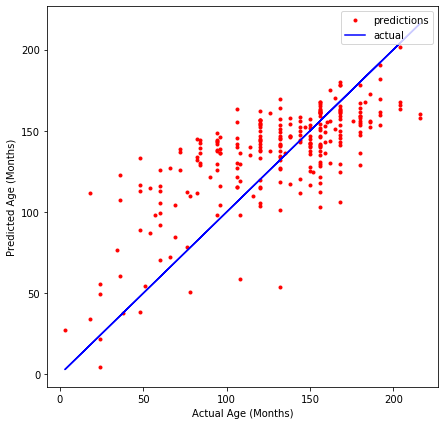

In [41]:
fig, ax = plt.subplots(figsize = (7,7))
ax.plot(test_months, pred, 'r.', label = 'predictions')
ax.plot(test_months, test_months, 'b-', label = 'actual')
ax.legend(loc = 'upper right')
ax.set_xlabel('Actual Age (Months)')
ax.set_ylabel('Predicted Age (Months)')

In [42]:
#Predict age from test images
test_generator.reset()
y_pred = model.predict_generator(test_generator)
predicted = y_pred.flatten()
predicted_months = mean_age + std_age*(predicted)

# test_generator.reset()
# y_pred = model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)
# predicted = y_pred.flatten()
# predicted_months = mean_age + std_age*(predicted)

W1123 21:53:58.047891 140170263959360 deprecation.py:323] From <ipython-input-42-4fc2130b3bb4>:3: Model.predict_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.predict, which supports generators.


Text(0, 0.5, 'Predicted Age (Months)')

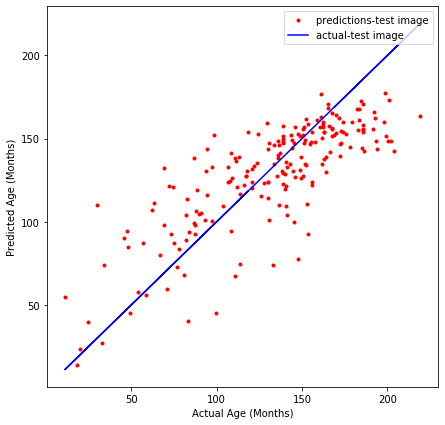

In [43]:
# PLot-actual vs predicted age from test image
fig, ax = plt.subplots(figsize = (7,7))
ax.plot(test_df['Ground truth bone age (months)'], predicted_months, 'r.', label = 'predictions-test image')
ax.plot(test_df['Ground truth bone age (months)'], test_df['Ground truth bone age (months)'], 'b-', label = 'actual-test image')
ax.legend(loc = 'upper right')
ax.set_xlabel('Actual Age (Months)')
ax.set_ylabel('Predicted Age (Months)')

### Pre-trained model- Xception

In [44]:
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense,Flatten
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import Sequential

model_1 = tf.keras.applications.xception.Xception(input_shape = (img_size, img_size, 3),
                                           include_top = False,
                                           weights = 'imagenet')
model_1.trainable = True
model_2 = Sequential()
model_2.add(model_1)
model_2.add(GlobalMaxPooling2D())
model_2.add(Flatten())
model_2.add(Dense(128, activation = 'relu')) # changed from 10 to 64
model_2.add(Dense(128, activation = 'relu')) # added
model_2.add(Dense(1, activation = 'linear'))


#compile model
model_2.compile(loss ='mse', optimizer= 'adam', metrics = [mae_in_months] )

#model summary
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 21,140,393
Trainable params: 21,085,865
Non-trainable params: 54,528
_____________________________________

Epoch 1/20
73/73 [==============================] - 654s 9s/step - loss: 0.7884 - mae_in_months: 31.5384 - val_loss: 9.6450 - val_mae_in_months: 128.6204
Epoch 2/20
73/73 [==============================] - 642s 9s/step - loss: 0.2370 - mae_in_months: 17.3864 - val_loss: 0.4286 - val_mae_in_months: 24.2943
Epoch 3/20
73/73 [==============================] - 643s 9s/step - loss: 0.1294 - mae_in_months: 13.1622 - val_loss: 0.1962 - val_mae_in_months: 15.6830
Epoch 4/20
73/73 [==============================] - 680s 9s/step - loss: 0.0979 - mae_in_months: 11.3345 - val_loss: 0.2080 - val_mae_in_months: 16.7925
Epoch 5/20
73/73 [==============================] - 656s 9s/step - loss: 0.0858 - mae_in_months: 10.5525 - val_loss: 0.1811 - val_mae_in_months: 15.3233
Epoch 6/20
73/73 [==============================] - 659s 9s/step - loss: 0.0730 - mae_in_months: 9.6697 - val_loss: 0.1885 - val_mae_in_months: 15.7084
Epoch 7/20
73/73 [==============================] - 669s 9s/step - loss: 0.0578 - 

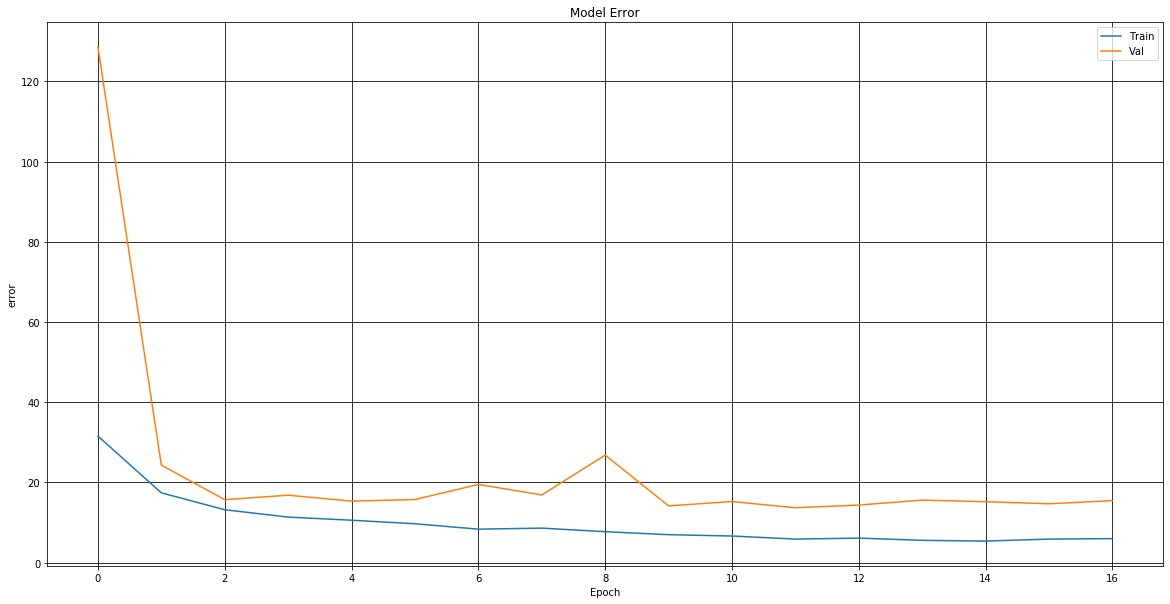

In [48]:
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 5,
                              verbose=0, mode='auto')
#model checkpoint
mc = ModelCheckpoint('best_model_2.h5', monitor='val_loss', mode='min', save_best_only=True)

#reduce lr on plateau
red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# callbacks = [tensorboard_callback,early_stopping,mc, red_lr_plat]
callbacks = [early_stopping,mc, red_lr_plat]

#fit model
history = model_2.fit(train_generator,
                            steps_per_epoch = STEP_SIZE_TRAIN,
                            validation_data = valid_generator,
                            validation_steps = STEP_SIZE_VALID,
                            epochs = 20,
                            callbacks= callbacks)
history
plot_it(history)

#### Predicting on validation data

8/8 [==============================] - 11s 1s/step


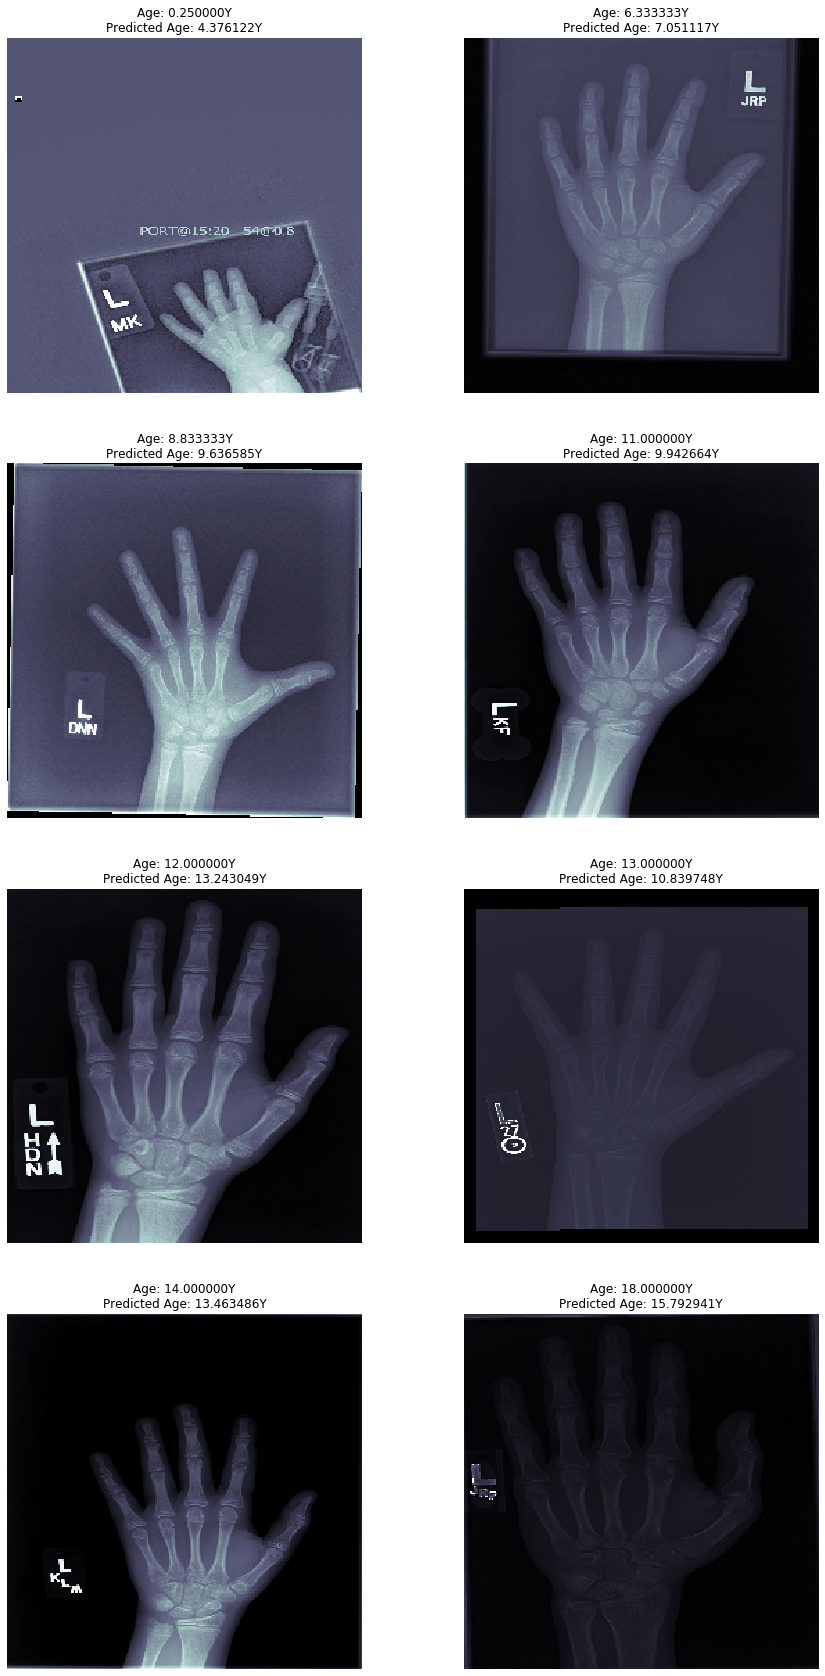

In [45]:
model_2.load_weights('best_model_2.h5')
pred_2 = mean_age + std_age*(model_2.predict(test_X, batch_size = 32, verbose = True))
test_months_2 = mean_age + std_age*(test_Y)

ord_ind_2 = np.argsort(test_Y)
ord_ind_2 = ord_ind_2[np.linspace(0, len(ord_ind_2)-1, 8).astype(int)] # take 8 evenly spaced ones
fig, axs = plt.subplots(4, 2, figsize = (15, 30))
for (ind, ax) in zip(ord_ind_2, axs.flatten()):
    ax.imshow(test_X[ind, :,:,0], cmap = 'bone')
    ax.set_title('Age: %fY\nPredicted Age: %fY' % (test_months_2[ind]/12.0, 
                                                           pred_2[ind]/12.0))
    ax.axis('off')
fig.savefig('trained_image_predictions.png', dpi = 300)

Text(0, 0.5, 'Predicted Age (Months)')

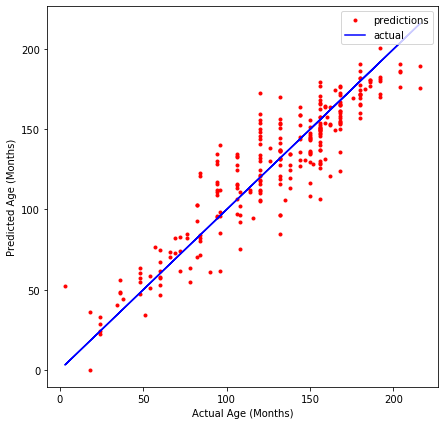

In [46]:
# Plot- precitons vs actual age using validation data
fig, ax = plt.subplots(figsize = (7,7))
ax.plot(test_months_2, pred_2, 'r.', label = 'predictions')
ax.plot(test_months_2, test_months_2, 'b-', label = 'actual')
ax.legend(loc = 'upper right')
ax.set_xlabel('Actual Age (Months)')
ax.set_ylabel('Predicted Age (Months)')

In [47]:
#Predict age from test images
test_generator.reset()
y_pred_2 = model_2.predict(test_generator)
predicted_2 = y_pred_2.flatten()
predicted_months_2 = mean_age + std_age*(predicted_2)
# test_generator.reset()
# y_pred_2 = model_2.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)
# predicted_2 = y_pred_2.flatten()
# predicted_months_2 = mean_age + std_age*(predicted_2)

Text(0, 0.5, 'Predicted Age (Months)')

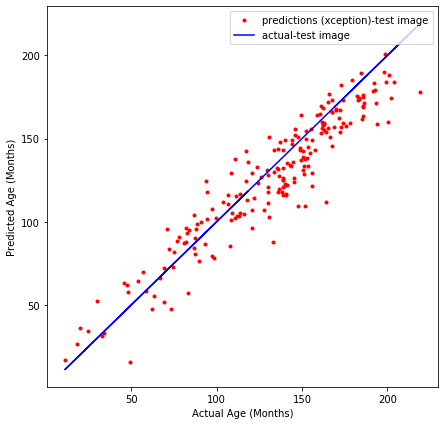

In [48]:
# PLot-actual vs predicted age from test image
fig, ax = plt.subplots(figsize = (7,7))
ax.plot(test_df['Ground truth bone age (months)'], predicted_months_2, 'r.', label = 'predictions (xception)-test image')
ax.plot(test_df['Ground truth bone age (months)'], test_df['Ground truth bone age (months)'], 'b-', label = 'actual-test image')
ax.legend(loc = 'upper right')
ax.set_xlabel('Actual Age (Months)')
ax.set_ylabel('Predicted Age (Months)')

In [1]:
#test data generator
# test_data_generator_2 = ImageDataGenerator(preprocessing_function = preprocess_input)

# test_generator_2 = test_data_generator_2.flow_from_dataframe(
#     dataframe = test_df,
#     directory = '/storage/mini_data/test/test/',
#     x_col = 'Case ID',
#     y_col = 'Ground truth bone age (months)',
#     batch_size = 200,
#     seed = 42,
#     shuffle = False,
#     class_mode = 'raw',
#     flip_vertical = True,
#     color_mode = 'rgb',
#     target_size = (img_size, img_size))

In [3]:
# test_generator_2.reset()
# pred_test=model_2.predict(test_generator_2,
# steps=STEP_SIZE_TEST_2,verbose=1)
# predicted_test = pred_test.flatten()
# predicted_test_months = mean_age + std_age*(predicted_test)

In [2]:
# PLot-actual vs predicted age from test image
# fig, ax = plt.subplots(figsize = (7,7))
# ax.plot(test_df['Ground truth bone age (months)'], predicted_test_months, 'r.', label = 'predictions (xception)-test image')
# ax.plot(test_df['Ground truth bone age (months)'], test_df['Ground truth bone age (months)'], 'b-', label = 'actual-test image')
# ax.legend(loc = 'upper right')
# ax.set_xlabel('Actual Age (Months)')
# ax.set_ylabel('Predicted Age (Months)')

### Pre-trained model- Xception (Male-only data)

In [41]:
#train data generator
train_generator_3 = train_data_generator.flow_from_dataframe(
    dataframe = train_df_male,
    directory = train_img_dir,
    x_col= 'id',
    y_col= 'scale_bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode= 'raw',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

#validation data generator
valid_generator_3 = valid_data_generator.flow_from_dataframe(
    dataframe = valid_df_male,
    directory = valid_img_dir,
    x_col = 'Image ID',
    y_col = 'scale_bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'raw',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

Found 1316 validated image filenames.
Found 434 validated image filenames.


In [42]:
STEP_SIZE_TRAIN_3=train_generator_3.n//train_generator_3.batch_size
STEP_SIZE_VALID_3=valid_generator_3.n//valid_generator_3.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Epoch 1/20
41/41 [==============================] - 378s 9s/step - loss: 1.2884 - mae_in_months: 40.2161 - val_loss: 2.0098 - val_mae_in_months: 56.4262
Epoch 2/20
41/41 [==============================] - 375s 9s/step - loss: 0.7161 - mae_in_months: 31.2338 - val_loss: 1.4091 - val_mae_in_months: 39.3225
Epoch 3/20
41/41 [==============================] - 370s 9s/step - loss: 0.3347 - mae_in_months: 20.5380 - val_loss: 7.5631 - val_mae_in_months: 109.1945
Epoch 4/20
41/41 [==============================] - 371s 9s/step - loss: 0.2031 - mae_in_months: 15.6852 - val_loss: 1.5550 - val_mae_in_months: 48.8019
Epoch 5/20
41/41 [==============================] - 374s 9s/step - loss: 0.1405 - mae_in_months: 13.1701 - val_loss: 1.0055 - val_mae_in_months: 38.2711
Epoch 6/20
41/41 [==============================] - 380s 9s/step - loss: 0.1165 - mae_in_months: 11.9054 - val_loss: 0.4580 - val_mae_in_months: 26.4262
Epoch 7/20
41/41 [==============================] - 373s 9s/step - loss: 0.0820 -

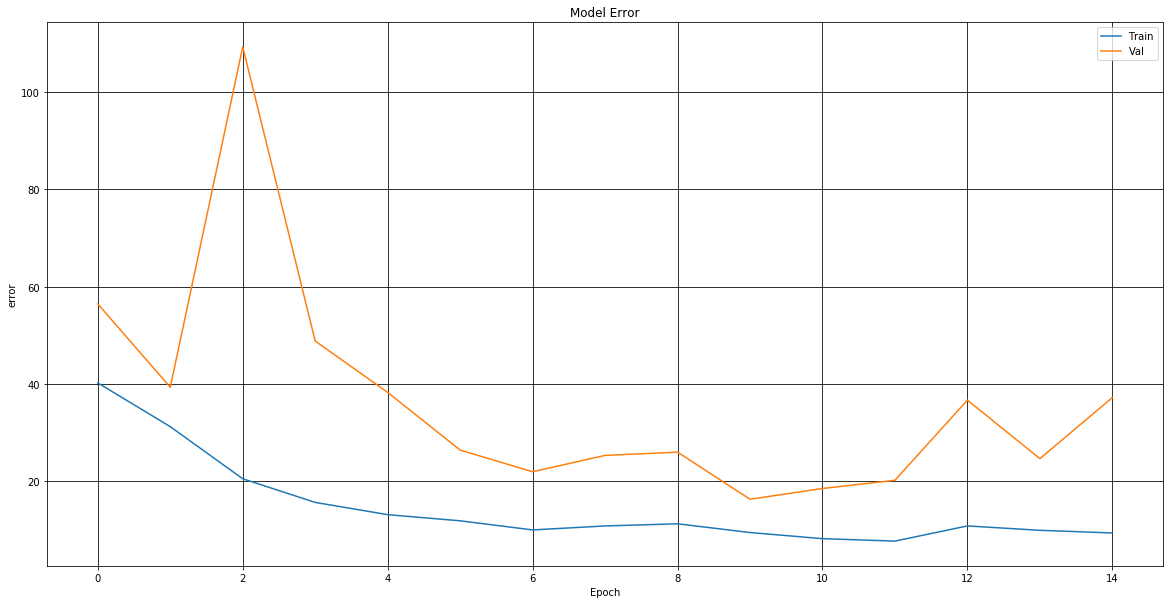

In [79]:
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 5,
                              verbose=0, mode='auto')
#model checkpoint
mc = ModelCheckpoint('best_model_3.h5', monitor='val_loss', mode='min', save_best_only=True)

#reduce lr on plateau
red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# callbacks = [tensorboard_callback,early_stopping,mc, red_lr_plat]
callbacks = [early_stopping,mc, red_lr_plat]

#fit model
history_3 = model_2.fit(train_generator_3,
                            steps_per_epoch = STEP_SIZE_TRAIN_3,
                            validation_data = valid_generator_3,
                            validation_steps = STEP_SIZE_VALID_3,
                            epochs = 20,
                            callbacks= callbacks)
history_3
plot_it(history_3)

In [47]:
test_X_3, test_Y_3 = next(valid_data_generator.flow_from_dataframe( 
                            valid_df_male, 
                            directory = valid_img_dir,
                            x_col = 'Image ID',
                            y_col = 'scale_bone_age_z', 
                            target_size = (img_size, img_size),
                            batch_size = 256,
                            class_mode = 'raw'
                            )) 

Found 434 validated image filenames.


8/8 [==============================] - 12s 1s/step


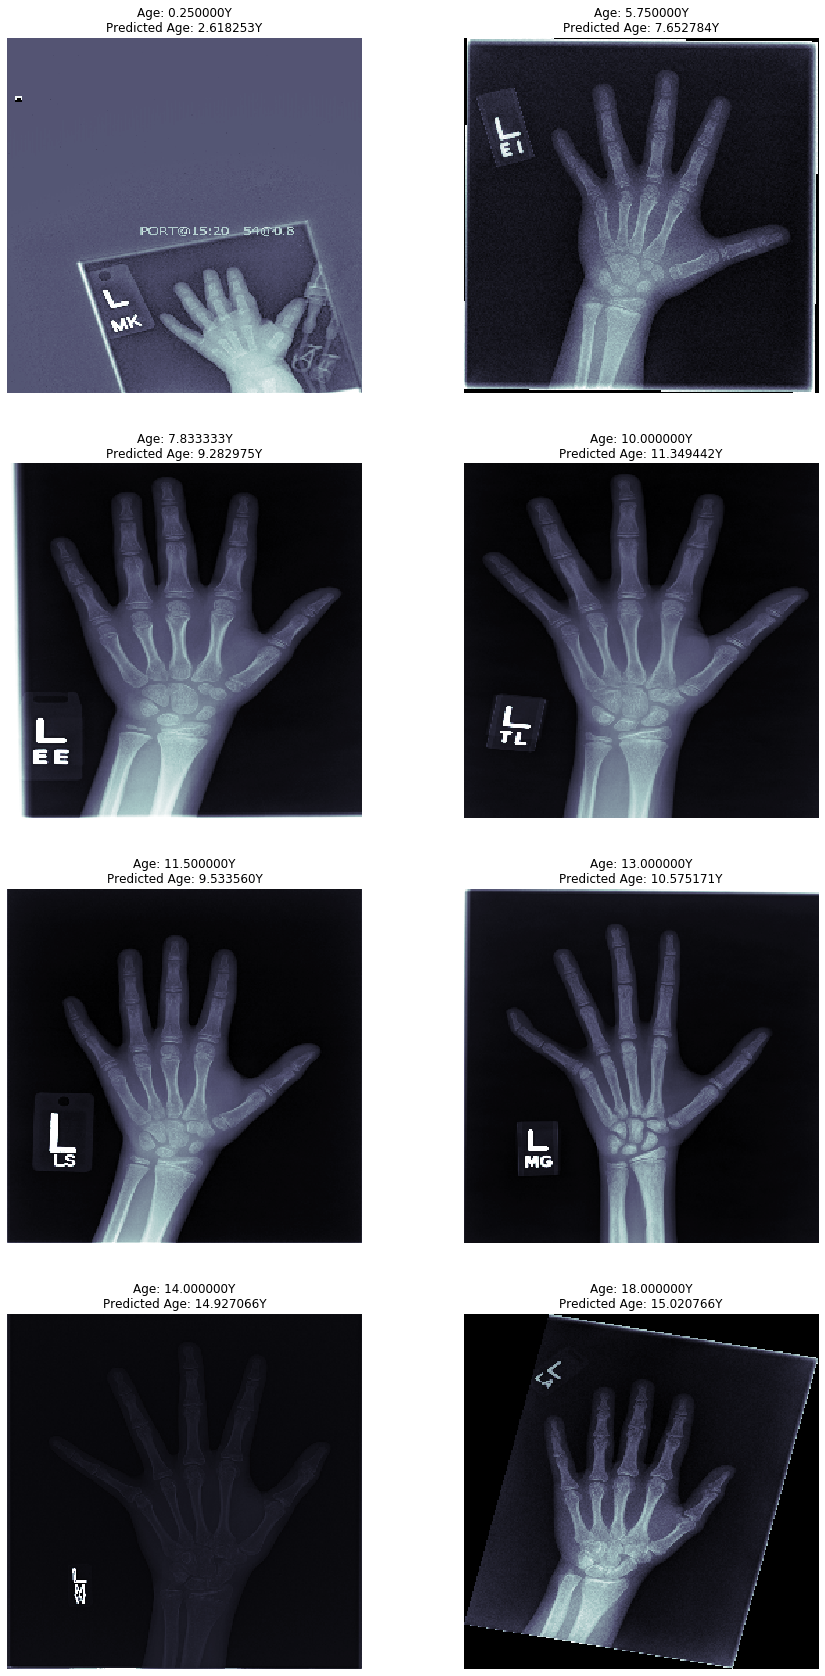

In [85]:
# Prediction on validation images
model_2.load_weights('best_model_3.h5')
pred_3 = mean_age + std_age*(model_2.predict(test_X_3, batch_size = 32, verbose = True))
test_months_3 = mean_age + std_age*(test_Y_3)

ord_ind_3 = np.argsort(test_Y_3)
ord_ind_3 = ord_ind_3[np.linspace(0, len(ord_ind_3)-1, 8).astype(int)] # take 8 evenly spaced ones
fig, axs = plt.subplots(4, 2, figsize = (15, 30))
for (ind, ax) in zip(ord_ind_3, axs.flatten()):
    ax.imshow(test_X_3[ind, :,:,0], cmap = 'bone')
    ax.set_title('Age: %fY\nPredicted Age: %fY' % (test_months_3[ind]/12.0, 
                                                           pred_3[ind]/12.0))
    ax.axis('off')
fig.savefig('trained_image_predictions.png', dpi = 300)

Text(0, 0.5, 'Predicted Age (Months)')

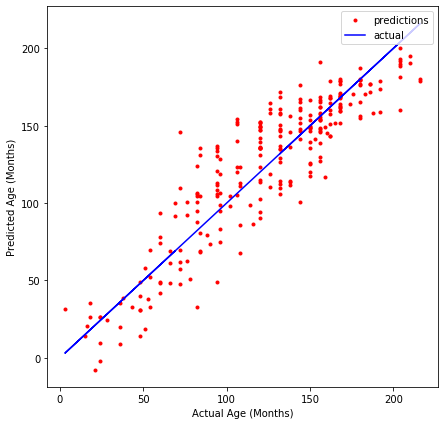

In [86]:
# Plot- Predictions vs actual images using validation images (Male-only images)
fig, ax = plt.subplots(figsize = (7,7))
ax.plot(test_months_3, pred_3, 'r.', label = 'predictions')
ax.plot(test_months_3, test_months_3, 'b-', label = 'actual')
ax.legend(loc = 'upper right')
ax.set_xlabel('Actual Age (Months)')
ax.set_ylabel('Predicted Age (Months)')

### Pre-trained model- Xception (Female-only data)

In [43]:
#train data generator
train_generator_f = train_data_generator.flow_from_dataframe(
    dataframe = train_df_female,
    directory = train_img_dir,
    x_col= 'id',
    y_col= 'scale_bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode= 'raw',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

#validation data generator
valid_generator_f = valid_data_generator.flow_from_dataframe(
    dataframe = valid_df_female,
    directory = valid_img_dir,
    x_col = 'Image ID',
    y_col = 'scale_bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'raw',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

Found 1042 validated image filenames.
Found 366 validated image filenames.


In [44]:
STEP_SIZE_TRAIN_f=train_generator_f.n//train_generator_f.batch_size
STEP_SIZE_VALID_f=valid_generator_f.n//valid_generator_f.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Epoch 1/20
32/32 [==============================] - 297s 9s/step - loss: 0.1793 - mae_in_months: 15.2285 - val_loss: 0.2941 - val_mae_in_months: 20.3864
Epoch 2/20
32/32 [==============================] - 293s 9s/step - loss: 0.1164 - mae_in_months: 12.3835 - val_loss: 0.4770 - val_mae_in_months: 25.8856
Epoch 3/20
32/32 [==============================] - 294s 9s/step - loss: 0.0941 - mae_in_months: 11.2373 - val_loss: 0.1973 - val_mae_in_months: 16.7050
Epoch 4/20
32/32 [==============================] - 293s 9s/step - loss: 0.0610 - mae_in_months: 8.9731 - val_loss: 0.1626 - val_mae_in_months: 15.0387
Epoch 5/20
32/32 [==============================] - 293s 9s/step - loss: 0.0457 - mae_in_months: 7.7369 - val_loss: 0.1850 - val_mae_in_months: 16.2776
Epoch 6/20
32/32 [==============================] - 292s 9s/step - loss: 0.0420 - mae_in_months: 6.7957 - val_loss: 0.1914 - val_mae_in_months: 16.8972
Epoch 7/20
32/32 [==============================] - 291s 9s/step - loss: 0.0365 - mae

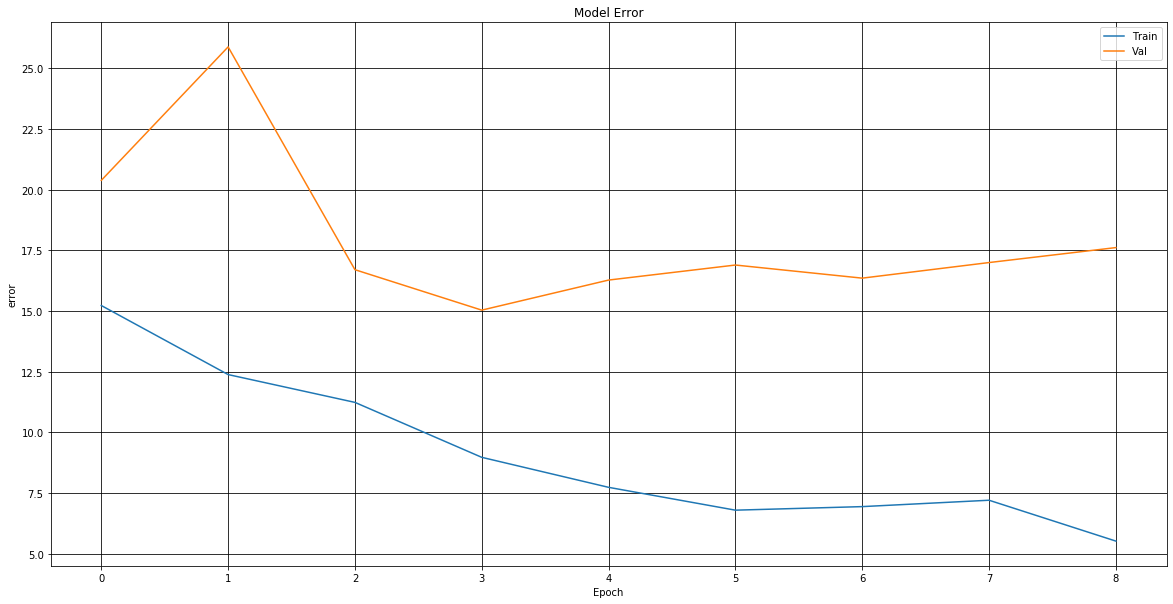

In [90]:
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 5,
                              verbose=0, mode='auto')
#model checkpoint
mc = ModelCheckpoint('best_model_f.h5', monitor='val_loss', mode='min', save_best_only=True)

#reduce lr on plateau
red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# callbacks = [tensorboard_callback,early_stopping,mc, red_lr_plat]
callbacks = [early_stopping,mc, red_lr_plat]

#fit model
history_f = model_2.fit(train_generator_f,
                            steps_per_epoch = STEP_SIZE_TRAIN_f,
                            validation_data = valid_generator_f,
                            validation_steps = STEP_SIZE_VALID_f,
                            epochs = 20,
                            callbacks= callbacks)
history_f
plot_it(history_f)

In [48]:
test_X_f, test_Y_f = next(valid_data_generator.flow_from_dataframe( 
                            valid_df_female, 
                            directory = valid_img_dir,
                            x_col = 'Image ID',
                            y_col = 'scale_bone_age_z', 
                            target_size = (img_size, img_size),
                            batch_size = 256,
                            class_mode = 'raw'
                            )) 

Found 366 validated image filenames.


8/8 [==============================] - 11s 1s/step


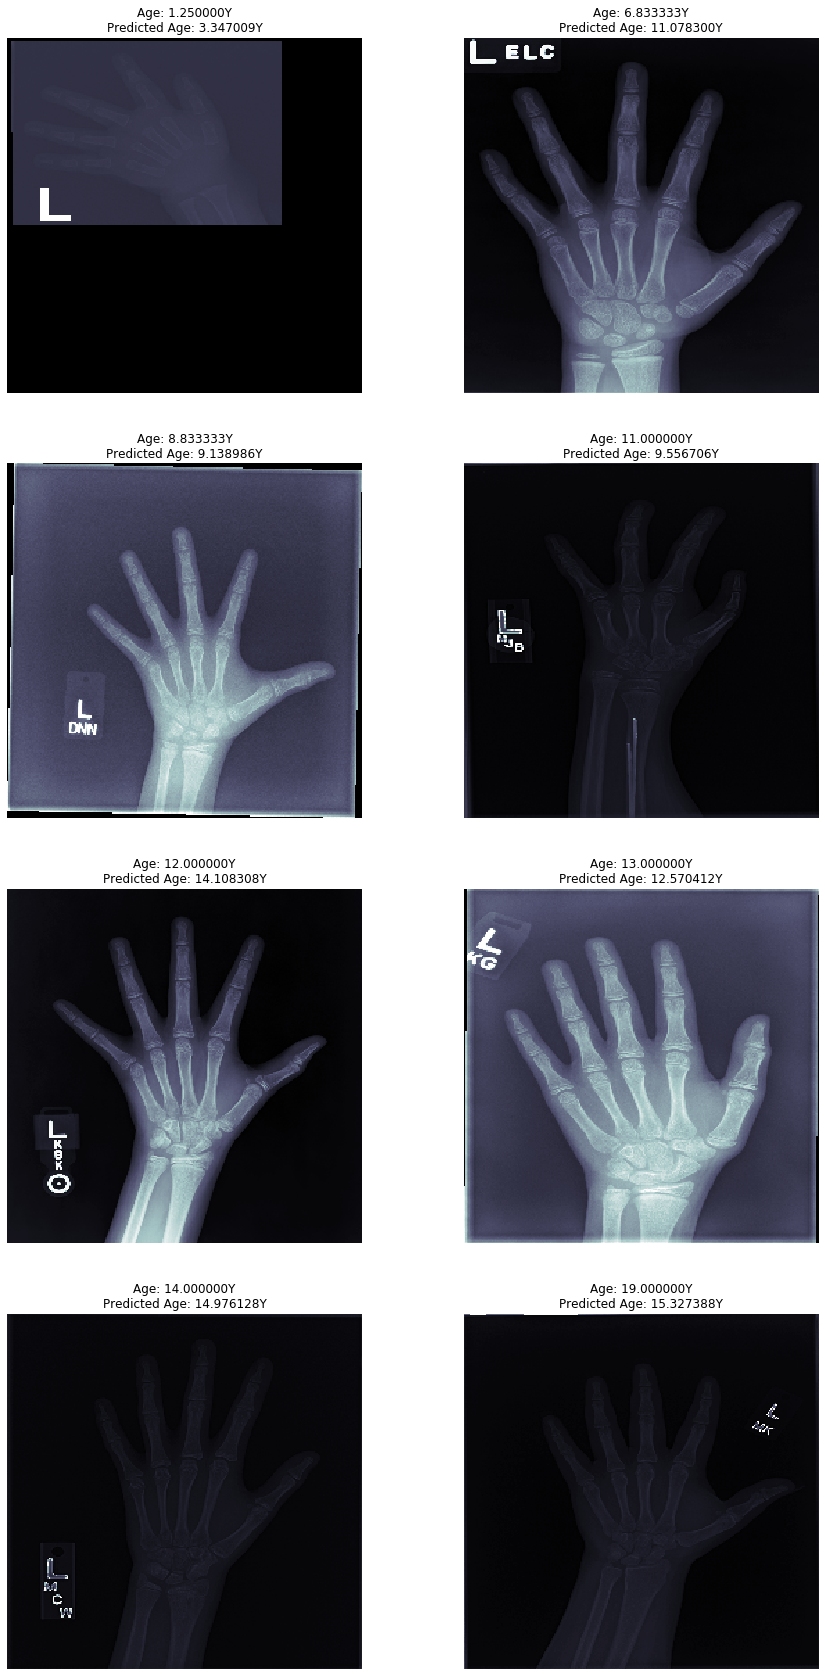

In [49]:
# Prediction on validation images
model_2.load_weights('best_model_3.h5')
pred_f = mean_age + std_age*(model_2.predict(test_X_f, batch_size = 32, verbose = True))
test_months_f = mean_age + std_age*(test_Y_f)

ord_ind_f = np.argsort(test_Y_f)
ord_ind_f = ord_ind_f[np.linspace(0, len(ord_ind_f)-1, 8).astype(int)] # take 8 evenly spaced ones
fig, axs = plt.subplots(4, 2, figsize = (15, 30))
for (ind, ax) in zip(ord_ind_f, axs.flatten()):
    ax.imshow(test_X_f[ind, :,:,0], cmap = 'bone')
    ax.set_title('Age: %fY\nPredicted Age: %fY' % (test_months_f[ind]/12.0, 
                                                           pred_f[ind]/12.0))
    ax.axis('off')
fig.savefig('trained_image_predictions.png', dpi = 300)

Text(0, 0.5, 'Predicted Age (Months)')

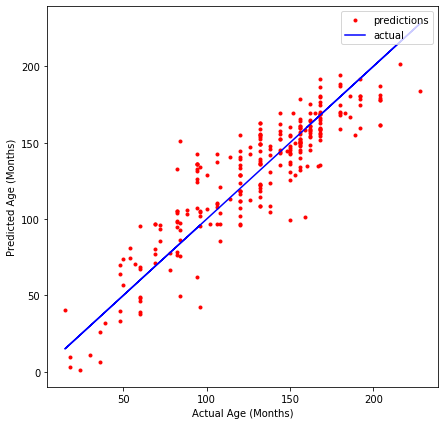

In [50]:
# Plot- Predictions vs actual images using validation images (Male-only images)
fig, ax = plt.subplots(figsize = (7,7))
ax.plot(test_months_f, pred_f, 'r.', label = 'predictions')
ax.plot(test_months_f, test_months_f, 'b-', label = 'actual')
ax.legend(loc = 'upper right')
ax.set_xlabel('Actual Age (Months)')
ax.set_ylabel('Predicted Age (Months)')

In [ ]:
# Prediction on test data
# test_generator.reset()
# y_pred = model_2.predict(test_generator)
# predicted = y_pred.flatten()
# predicted_months = mean_bone_age + std_bone_age*(predicted)
# filenames=test_generator.filenames
# results=pd.DataFrame({"Filename":filenames,
#                       "Predictions": predicted_months})
# results.to_csv("results.csv",index=False)
# results.head()